In [1]:
"""
Implementation of an attention-based model for item recommendation.

Cf. "Attention-Based Transactional Context Embedding for Next-Item Recommendation".
Wang et al. (2018).
"""


'\nImplementation of an attention-based model for item recommendation.\n\nCf. "Attention-Based Transactional Context Embedding for Next-Item Recommendation".\nWang et al. (2018).\n'

In [2]:
import json
from pathlib import Path
import os
import sys

sys.path.append("./../../")
print(os.getcwd())

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm

from choice_learn.basket_models import TripDataset
from choice_learn.basket_models.attn_model import AttentionBasedContextEmbedding
from choice_learn.basket_models.synthetic_dataset import SyntheticDataGenerator

/home/souleiman_sbai/Artefact_souli/choice-learn/notebooks/basket_models


2025-07-25 11:56:13.435746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753437373.447509  555347 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753437373.450978  555347 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753437373.461332  555347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753437373.461346  555347 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753437373.461348  555347 computation_placer.cc:177] computation placer alr

In [3]:
# Parameters

n_baskets = 2000
epochs = 400
lr = 0.01
embedding_dim = 3
n_negative_samples = 3

In [4]:
# Generate synthetic dataset

data_gen = SyntheticDataGenerator()
data_gen.instantiate(
    proba_complementary_items=0.7,
    proba_neutral_items=0.3,
    noise_proba=0.15,
)
trip_dataset = data_gen.generate_trip_dataset(n_baskets)

W0000 00:00:1753437386.531137  555347 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epode:  400


Training Epochs:   0%|                                                                                                            | 0/400 [00:00<?, ?it/s]W0000 00:00:1753437387.823032  555347 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedConcat/assert_equal_1/Assert/AssertGuard/branch_executed/_489
W0000 00:00:1753437390.030828  555347 loop_optimizer.cc:934] Skipping loop optimization for Merge node with control input: StatefulPartitionedCall/RaggedConcat/assert_equal_1/Assert/AssertGuard/branch_executed/_489
Training Epochs: 100%|█████████████████████████████████████████| 400/400 [08:38<00:00,  1.30s/it, epoch_loss=tf.Tensor(8782.184, shape=(), dtype=float32)]


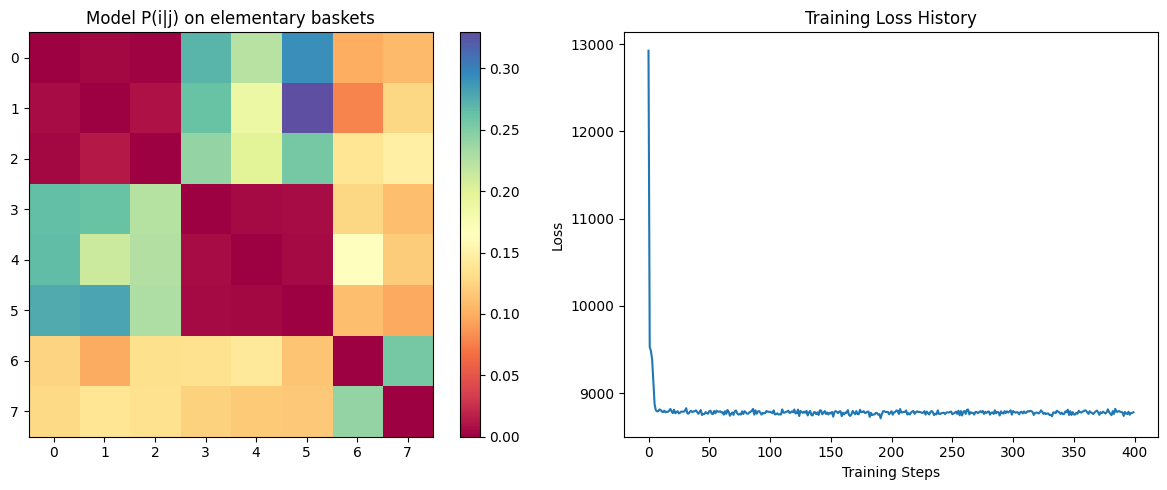

      Model Parameters
Epochs              : 400
Number of Trips     : 2000
n_negative_samples  : 3
Learning_rate       : 0.01
Loss type           : NCE Loss
Batch_size          : 50
Embedding_dim       : 3


In [5]:
# Instantiate and train the model

model1 = AttentionBasedContextEmbedding()
model1.instantiate(
    n_items=data_gen.assortment_matrix.shape[1],
    epochs=epochs,
    lr=lr,
    embedding_dim=embedding_dim,
    n_negative_samples=n_negative_samples,
)
model1.fit(trip_dataset, repr=True)

In [6]:
# Create evaluation dataset
eval_dataset = data_gen.generate_trip_dataset(100)

# Evaluate model
loss_eval_dataset_1 = model1.evaluate(eval_dataset)
print(f"Loss of model1 on the evaluation dataset {loss_eval_dataset_1}")

# Save model
model1.save_model("attn_model.json")

Loss of model1 on the evaluation dataset 2.0749382972717285


In [7]:
# Create a second model without instantiating
model2 = AttentionBasedContextEmbedding()

# Load first model and compare results on evaluation dataset
model2.load_model("attn_model.json")
loss_eval_dataset_2 = model2.evaluate(eval_dataset)
print(f"Loss of model2 on the evaluation dataset {loss_eval_dataset_2}")


Loss of model2 on the evaluation dataset 2.0749382972717285
